In [1]:
# ============================================================
# Fish Species Detection - Full Image-focused EDA (Kaggle Ready)
# ============================================================

import os, cv2, math, imagehash, numpy as np
from PIL import Image
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

root = Path("/kaggle/input/fishes/Fishes")

classes = sorted([d.name for d in root.iterdir() if d.is_dir()])
print("Total Classes:", len(classes))
classes


Total Classes: 21


['Baim',
 'Bata',
 'Batasio(tenra)',
 'Chitul',
 'Croaker(Poya)',
 'Hilsha',
 'Kajoli',
 'Meni',
 'Pabda',
 'Poli',
 'Puti',
 'Rita',
 'Rui',
 'Rupchada',
 'Silver Carp',
 'Telapiya',
 'carp',
 'k',
 'kaikka',
 'koral',
 'shrimp']

In [2]:
image_paths = []
labels = []

for cls in classes:
    for img in (root/cls).glob("*.*"):
        image_paths.append(str(img))
        labels.append(cls)

df = pd.DataFrame({"path": image_paths, "class": labels})
df.head()


,path,class
0,/kaggle/input/fishes/Fishes/Baim/IMG2025110114...,Baim
1,/kaggle/input/fishes/Fishes/Baim/IMG2025110114...,Baim
2,/kaggle/input/fishes/Fishes/Baim/IMG2025110114...,Baim
3,/kaggle/input/fishes/Fishes/Baim/IMG2025110114...,Baim
4,/kaggle/input/fishes/Fishes/Baim/IMG2025110114...,Baim


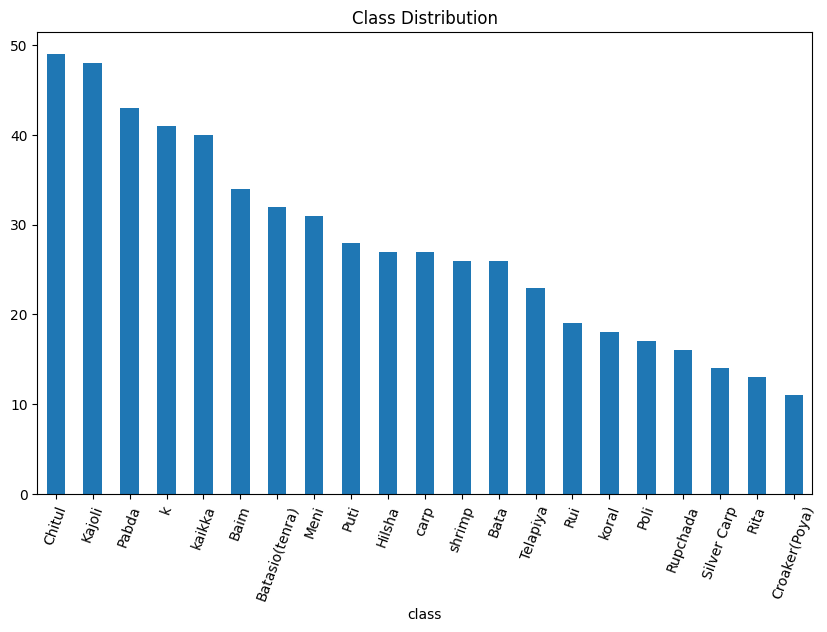

In [3]:
plt.figure(figsize=(10,6))
df['class'].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.xticks(rotation=70)
plt.show()


In [4]:
def get_info(p):
    img = Image.open(p).convert("RGB")
    arr = np.array(img)

    h, w = arr.shape[:2]
    aspect = w / h

    # Color stats
    mean_rgb = arr.mean(axis=(0,1))
    std_rgb = arr.std(axis=(0,1))

    hsv = cv2.cvtColor(arr, cv2.COLOR_RGB2HSV)
    mean_hsv = hsv.mean(axis=(0,1))

    # brightness
    brightness = arr.mean()

    # contrast
    contrast = arr.std()

    # saturation clipping
    sat_clip = np.sum(hsv[:,:,1] > 250) / (h*w)

    # sharpness
    sharp = cv2.Laplacian(arr, cv2.CV_64F).var()

    # noise proxy
    gray = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
    noise_score = cv2.Laplacian(gray, cv2.CV_64F).var()

    # perceptual hash
    ph = str(imagehash.phash(img))

    return [w, h, aspect, *mean_rgb, *std_rgb, *mean_hsv,
            brightness, contrast, sat_clip, sharp, noise_score, ph]

cols = ["w","h","aspect",
        "mean_r","mean_g","mean_b",
        "std_r","std_g","std_b",
        "mean_h","mean_s","mean_v",
        "brightness","contrast","sat_clip",
        "sharpness","noise","phash"]

meta = []
for p in tqdm(df.path):
    meta.append(get_info(p))

meta = pd.DataFrame(meta, columns=cols)
full = pd.concat([df, meta], axis=1)
full.head()


100%|██████████| 583/583 [12:40<00:00,  1.30s/it]


,path,class,w,h,aspect,mean_r,mean_g,mean_b,std_r,std_g,std_b,mean_h,mean_s,mean_v,brightness,contrast,sat_clip,sharpness,noise,phash
0,/kaggle/input/fishes/Fishes/Baim/IMG2025110114...,Baim,2248,2986,0.752847,133.103923,131.668378,123.039520,56.672179,56.158552,56.863651,32.823896,26.272313,134.077962,129.270607,56.739944,0.000007,22.644198,22.156936,9c4933c6999b999a
1,/kaggle/input/fishes/Fishes/Baim/IMG2025110114...,Baim,2248,2986,0.752847,181.374987,180.607928,172.158997,29.987739,32.657045,37.627911,31.732786,17.109426,182.188788,178.047304,33.832475,0.000394,17.890436,17.573255,b3c606f94cdb58a1
2,/kaggle/input/fishes/Fishes/Baim/IMG2025110114...,Baim,2986,2249,1.327701,159.149307,156.336760,147.914476,40.551608,42.535812,47.051696,28.783723,22.428153,159.694910,154.466848,43.726216,0.000032,38.704063,38.296278,9414d76bd2d4655a
3,/kaggle/input/fishes/Fishes/Baim/IMG2025110114...,Baim,2986,2249,1.327701,159.895028,157.305036,150.487362,42.606860,44.014183,47.130158,31.444248,19.950053,160.665901,155.895808,44.799835,0.000354,20.321615,19.861218,c4bb884b2d9fd234
4,/kaggle/input/fishes/Fishes/Baim/IMG2025110114...,Baim,2986,2249,1.327701,159.148919,155.623711,147.354703,41.010199,43.032586,47.494504,26.186004,23.072024,159.485136,154.042444,44.206599,0.000045,37.448376,37.021500,9014d56b5ad4e57a


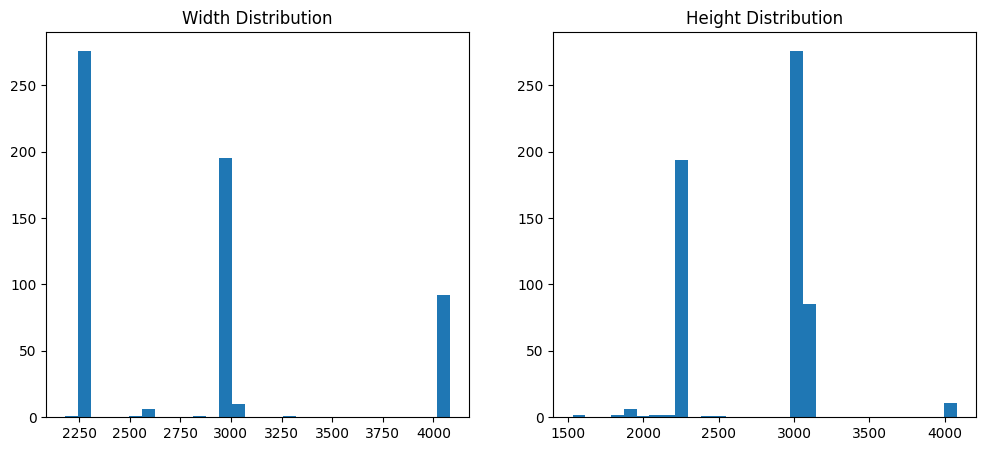

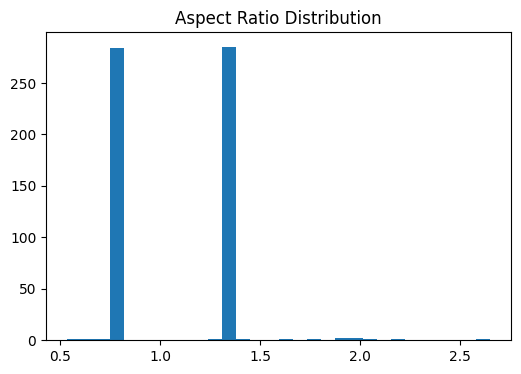

In [5]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(full['w'], bins=30)
plt.title("Width Distribution")

plt.subplot(1,2,2)
plt.hist(full['h'], bins=30)
plt.title("Height Distribution")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(full['aspect'], bins=30)
plt.title("Aspect Ratio Distribution")
plt.show()


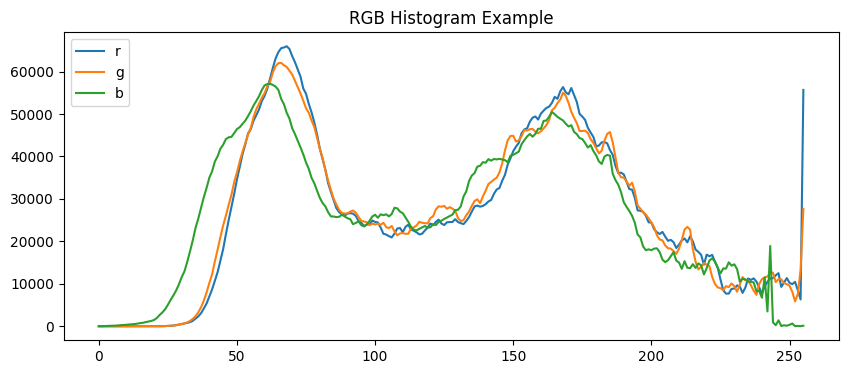

In [6]:
sample = cv2.imread(full.path.iloc[0])[:,:,::-1]

colors = ('r','g','b')
plt.figure(figsize=(10,4))
for i,col in enumerate(colors):
    hist = cv2.calcHist([sample],[i],None,[256],[0,256])
    plt.plot(hist, label=col)
plt.title("RGB Histogram Example")
plt.legend()
plt.show()


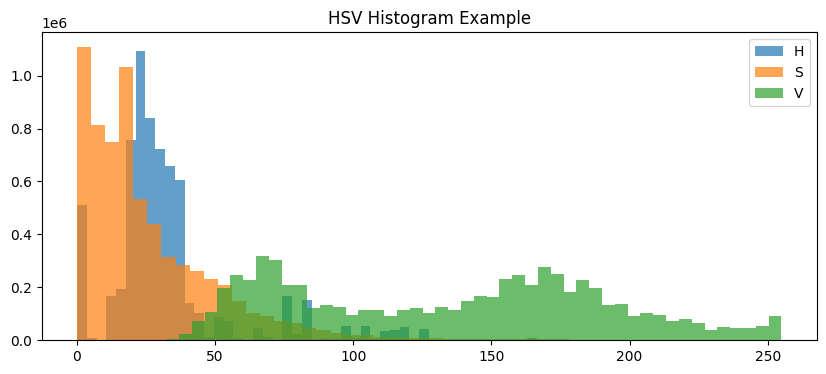

In [7]:
hsv = cv2.cvtColor(sample, cv2.COLOR_RGB2HSV)
plt.figure(figsize=(10,4))
plt.hist(hsv[:,:,0].ravel(), bins=50, alpha=0.7, label='H')
plt.hist(hsv[:,:,1].ravel(), bins=50, alpha=0.7, label='S')
plt.hist(hsv[:,:,2].ravel(), bins=50, alpha=0.7, label='V')
plt.legend()
plt.title("HSV Histogram Example")
plt.show()


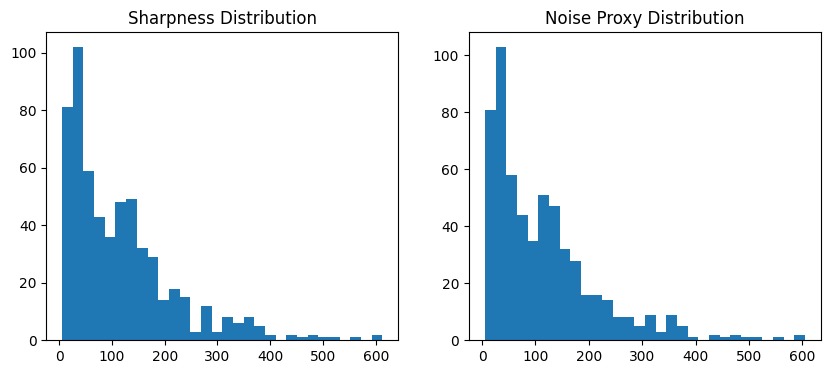

In [8]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(full['sharpness'], bins=30)
plt.title("Sharpness Distribution")

plt.subplot(1,2,2)
plt.hist(full['noise'], bins=30)
plt.title("Noise Proxy Distribution")
plt.show()


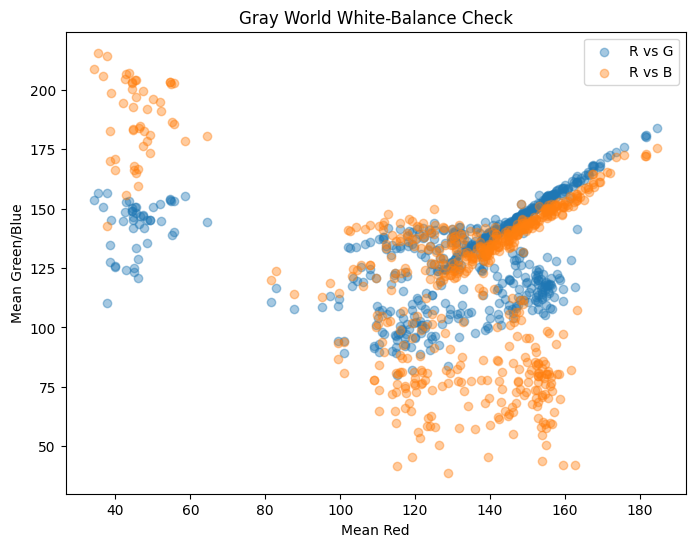

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(full['mean_r'], full['mean_g'], label="R vs G", alpha=0.4)
plt.scatter(full['mean_r'], full['mean_b'], label="R vs B", alpha=0.4)
plt.xlabel("Mean Red")
plt.ylabel("Mean Green/Blue")
plt.legend()
plt.title("Gray World White-Balance Check")
plt.show()


In [10]:
dups = full.groupby("phash").filter(lambda x: len(x)>1)
dups.head()


,path,class,w,h,aspect,mean_r,mean_g,mean_b,std_r,std_g,std_b,mean_h,mean_s,mean_v,brightness,contrast,sat_clip,sharpness,noise,phash
102,/kaggle/input/fishes/Fishes/Chitul/IMG20251029...,Chitul,2248,2986,0.752847,49.214600,145.318624,173.430249,76.236531,36.890684,40.687359,80.415163,188.556436,176.738263,122.654491,75.968526,0.549948,204.852693,204.062963,d9a725cc36196693
105,/kaggle/input/fishes/Fishes/Chitul/IMG20251029...,Chitul,2986,2249,1.327701,55.663760,153.166255,202.667698,83.124016,39.200683,41.242007,88.862863,186.906486,205.200057,137.165904,84.333257,0.500157,335.339950,320.688295,d58b6a6a3d85c662
108,/kaggle/input/fishes/Fishes/Chitul/IMG20251029...,Chitul,2986,2249,1.327701,54.882698,153.357524,202.549748,82.884773,38.873437,40.808391,87.676168,187.785202,205.082426,136.929990,84.368100,0.509216,330.092731,315.200582,d58b6a6a3d85c662
126,/kaggle/input/fishes/Fishes/Chitul/IMG20251029...,Chitul,2248,2986,0.752847,47.577952,141.899560,182.530793,74.973416,36.312970,41.877453,84.896631,190.147997,185.326498,124.002768,78.059685,0.560184,243.039867,242.162806,d9a725cc36196693
227,/kaggle/input/fishes/Fishes/Meni/IMG2025110114...,Meni,2248,2986,0.752847,152.417297,149.998584,145.635196,60.741018,62.942304,65.083967,40.954915,25.966806,154.286603,149.350359,63.009937,0.000834,24.444847,23.981060,b7f34e1e186c11b4


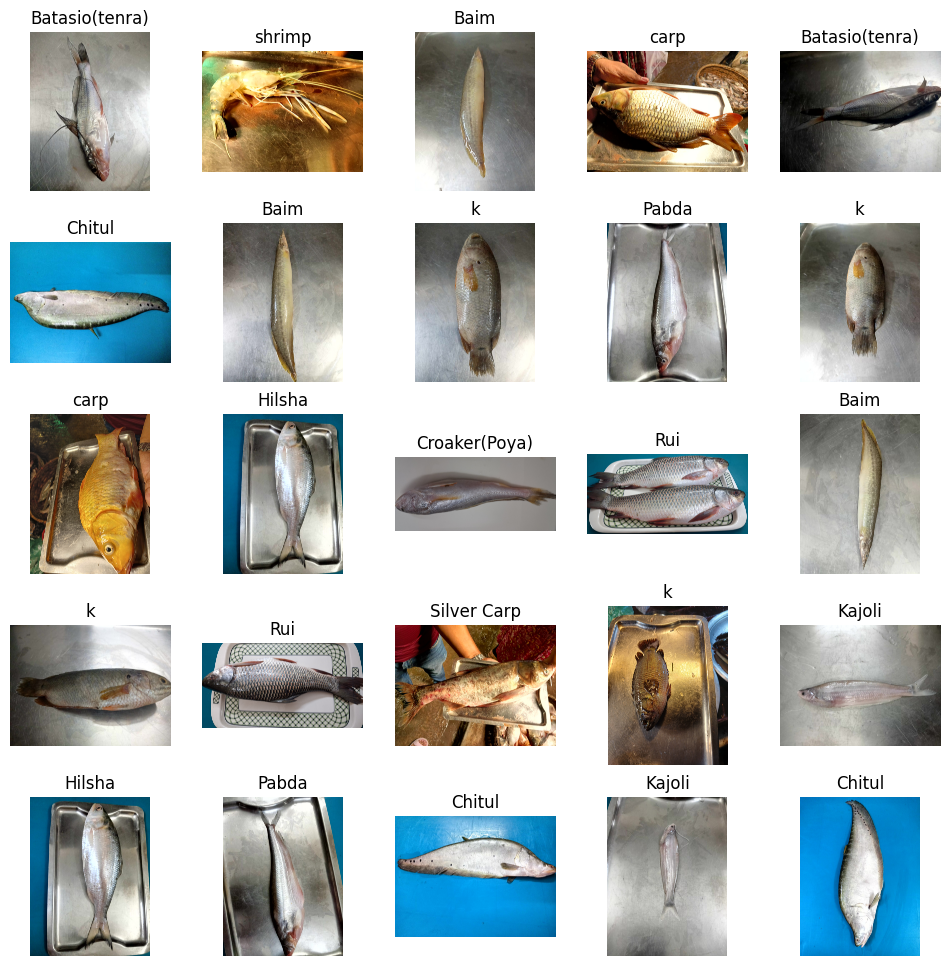

In [11]:
import random

fig, ax = plt.subplots(5,5, figsize=(12,12))

for i,a in enumerate(ax.flatten()):
    p = random.choice(full.path.tolist())
    img = cv2.imread(p)[:,:,::-1]
    a.imshow(img)
    a.set_title(Path(p).parent.name)
    a.axis("off")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


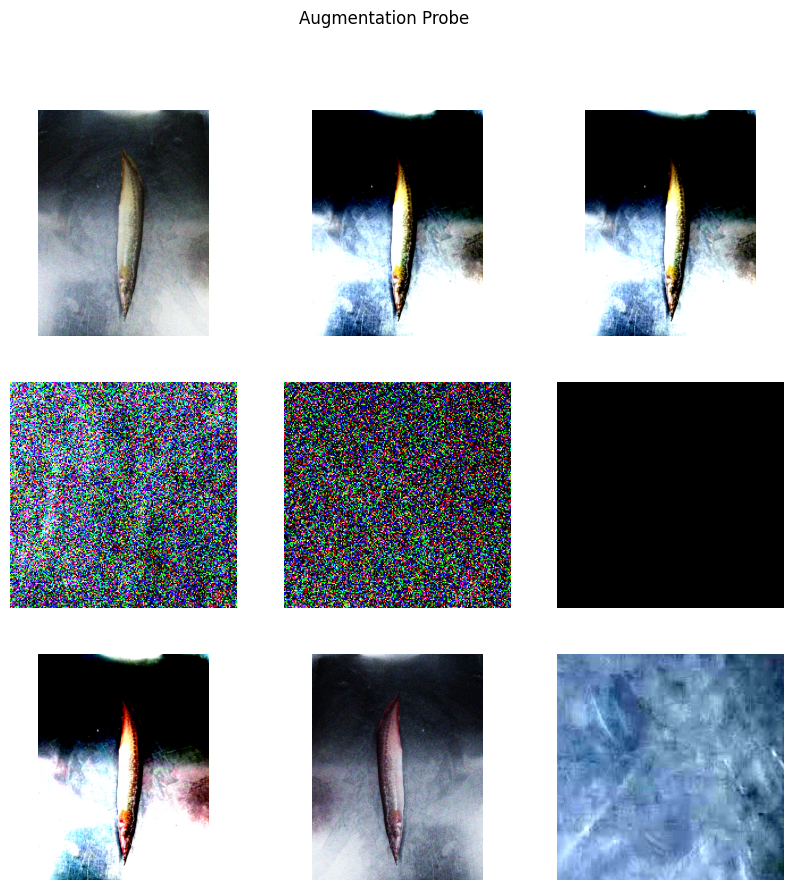

In [12]:
import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.3),
    A.RandomCrop(width=200, height=200, p=0.5),
    A.HueSaturationValue(p=0.3),
    A.GaussNoise(p=0.3),
    A.Normalize(),

])

sample_path = full.path.iloc[0]
img = cv2.imread(sample_path)[:,:,::-1]

plt.figure(figsize=(10,10))
for i in range(9):
    augmented = transform(image=img)['image']
    plt.subplot(3,3,i+1)
    plt.imshow(augmented)
    plt.axis('off')
plt.suptitle("Augmentation Probe")
plt.show()


In [13]:
import os
import cv2
from tqdm import tqdm
import albumentations as A
from PIL import Image
import numpy as np
from pathlib import Path

input_dir = Path("/kaggle/input/fishes/Fishes")
output_dir = Path("/kaggle/working/augmented")
output_dir.mkdir(exist_ok=True)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.3),
    A.RandomCrop(width=200, height=200, p=0.5),
    A.HueSaturationValue(p=0.3),
    A.GaussNoise(p=0.3),
])

for cls in os.listdir(input_dir):
    cls_path = input_dir / cls
    if not cls_path.is_dir():
        continue
    
    (output_dir / cls).mkdir(exist_ok=True)

    images = list(cls_path.glob("*.*"))
    
    for img_path in tqdm(images, desc=f"Augmenting {cls}"):
        img = cv2.imread(str(img_path))[:,:,::-1]
        
        # 5 augmentations per image
        for i in range(10):
            aug = transform(image=img)['image']
            aug = cv2.cvtColor(aug, cv2.COLOR_RGB2BGR)

            save_name = f"{img_path.stem}_aug_{i}.jpg"
            cv2.imwrite(str(output_dir/cls/save_name), aug)

print("DONE!")



Augmenting Croaker(Poya): 100%|██████████| 11/11 [00:24<00:00,  2.26s/it]

DONE!


In [14]:
aug_count = sum(len(files) for _,_,files in os.walk(output_dir))
print("TOTAL AUGMENTED IMAGES =", aug_count)


TOTAL AUGMENTED IMAGES = 5830


**Pretrained model**

In [15]:
import os
from pathlib import Path
from PIL import Image
from tqdm import tqdm

SRC = Path("/kaggle/working/augmented")
DST = Path("/kaggle/working/Fishes_resized")
DST.mkdir(parents=True, exist_ok=True)

TARGET_SIZE = (256, 256)   # যেকোনো সাইজ রাখতে পারবেন

for cls in sorted([d.name for d in SRC.iterdir() if d.is_dir()]):
    (DST/cls).mkdir(exist_ok=True)
    for img_path in tqdm(list((SRC/cls).glob("*.*")), desc=cls):
        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize(TARGET_SIZE, Image.BILINEAR)
            img.save(DST/cls/img_path.name)
        except:
            pass

print("DONE — All images resized!")


shrimp: 100%|██████████| 260/260 [00:17<00:00, 15.13it/s]

DONE — All images resized!


In [16]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cuda'

In [17]:
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

test_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])


In [18]:
data_root = "/kaggle/working/Fishes_resized"

full_dataset = datasets.ImageFolder(data_root, transform=train_tf)
class_names = full_dataset.classes
num_classes = len(class_names)

len(full_dataset), num_classes


(5830, 21)

In [19]:
val_size = int(0.2 * len(full_dataset))
train_size = len(full_dataset) - val_size

train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

# validationের tf ঠিক করা
val_ds.dataset.transform = test_tf


In [20]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)


In [21]:
model = models.googlenet(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 194MB/s] 


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [23]:
num_epochs = 30
best_val_loss = np.inf
patience = 5
wait = 0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):

    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = torch.max(outputs, 1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    model.eval()
    v_loss = 0
    v_correct = 0
    v_total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            v_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            v_correct += (pred == labels).sum().item()
            v_total += labels.size(0)

    val_loss = v_loss / len(val_loader)
    val_acc = v_correct / v_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f} "
          f"Train Acc: {train_acc:.4f} Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save(model.state_dict(), "best_googlenet.pth")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping...")
            break


Epoch [1/30] Train Loss: 2.0593 Val Loss: 1.3183 Train Acc: 0.4503 Val Acc: 0.6132
Epoch [2/30] Train Loss: 1.2772 Val Loss: 1.1062 Train Acc: 0.6259 Val Acc: 0.6424
Epoch [3/30] Train Loss: 1.0464 Val Loss: 1.0599 Train Acc: 0.6792 Val Acc: 0.6595
Epoch [4/30] Train Loss: 0.8652 Val Loss: 1.0344 Train Acc: 0.7281 Val Acc: 0.6569
Epoch [5/30] Train Loss: 0.7036 Val Loss: 1.0578 Train Acc: 0.7869 Val Acc: 0.6612
Epoch [6/30] Train Loss: 0.5274 Val Loss: 1.1070 Train Acc: 0.8435 Val Acc: 0.6698
Epoch [7/30] Train Loss: 0.4043 Val Loss: 1.1264 Train Acc: 0.8879 Val Acc: 0.6638
Epoch [8/30] Train Loss: 0.3074 Val Loss: 1.2456 Train Acc: 0.9177 Val Acc: 0.6509
Epoch [9/30] Train Loss: 0.2056 Val Loss: 1.3112 Train Acc: 0.9543 Val Acc: 0.6595
Early stopping...


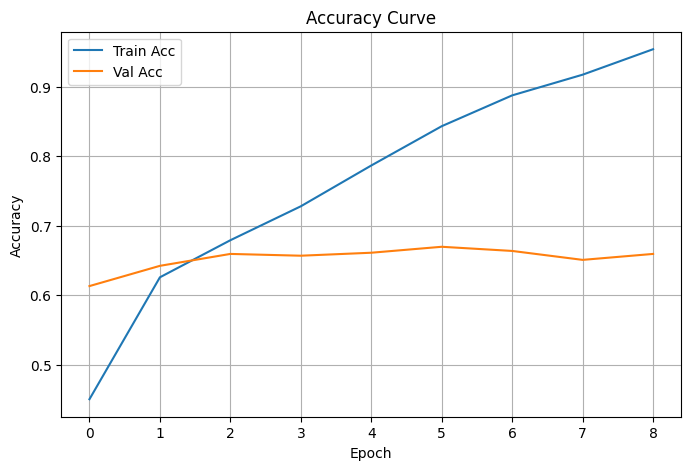

In [24]:
plt.figure(figsize=(8,5))
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


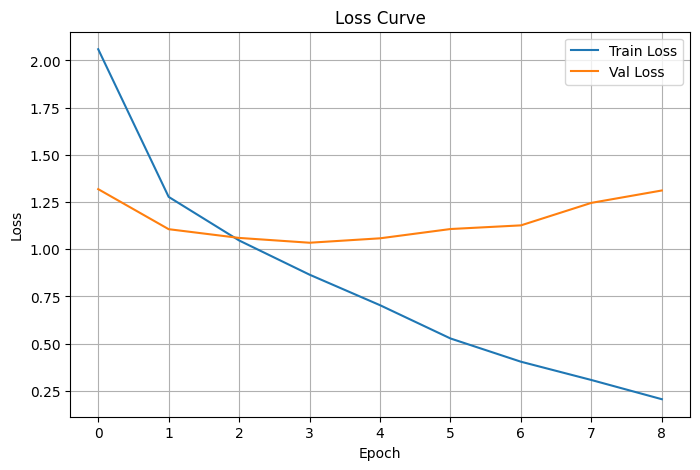

In [25]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


**Resnet50**

In [31]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize


In [32]:
model = models.resnet50(weights="IMAGENET1K_V2")
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [35]:
num_epochs = 30
best_val_loss = np.inf
patience = 5
wait = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

train_start = time.time()  # timing
for epoch in range(num_epochs):

    # TRAIN ------------------------
    model.train()
    running_loss, correct, total = 0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = torch.max(outputs, 1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # VAL ---------------------------
    model.eval()
    v_loss, v_correct, v_total = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            v_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            v_correct += (pred == labels).sum().item()
            v_total += labels.size(0)

    val_loss = v_loss / len(val_loader)
    val_acc = v_correct / v_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save(model.state_dict(), "best_resnet50.pth")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping...")
            break
            
train_end = time.time()
print(f"\nTraining Wall-clock Time: {train_end - train_start:.2f} sec")


Epoch 1/30 | Train Loss: 1.9002 | Val Loss: 1.1895 | Train Acc: 0.4670 | Val Acc: 0.6278
Epoch 2/30 | Train Loss: 1.1486 | Val Loss: 1.0762 | Train Acc: 0.6370 | Val Acc: 0.6475
Epoch 3/30 | Train Loss: 0.9410 | Val Loss: 1.0786 | Train Acc: 0.6985 | Val Acc: 0.6544
Epoch 4/30 | Train Loss: 0.7567 | Val Loss: 1.1495 | Train Acc: 0.7569 | Val Acc: 0.6578
Epoch 5/30 | Train Loss: 0.6021 | Val Loss: 1.0466 | Train Acc: 0.8165 | Val Acc: 0.6715
Epoch 6/30 | Train Loss: 0.4739 | Val Loss: 1.2418 | Train Acc: 0.8527 | Val Acc: 0.6664
Epoch 7/30 | Train Loss: 0.3523 | Val Loss: 1.2434 | Train Acc: 0.8926 | Val Acc: 0.6672
Epoch 8/30 | Train Loss: 0.2598 | Val Loss: 1.3443 | Train Acc: 0.9187 | Val Acc: 0.6767
Epoch 9/30 | Train Loss: 0.1892 | Val Loss: 1.3657 | Train Acc: 0.9432 | Val Acc: 0.6681
Epoch 10/30 | Train Loss: 0.1329 | Val Loss: 1.4653 | Train Acc: 0.9623 | Val Acc: 0.6750
Early stopping...

Training Wall-clock Time: 694.05 sec


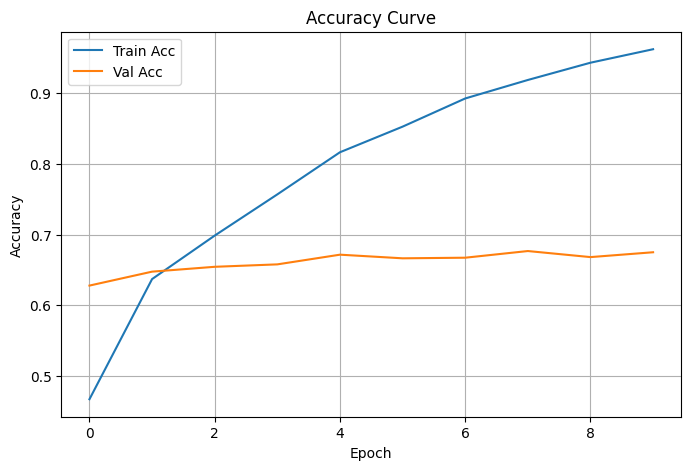

In [37]:
plt.figure(figsize=(8,5))
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()


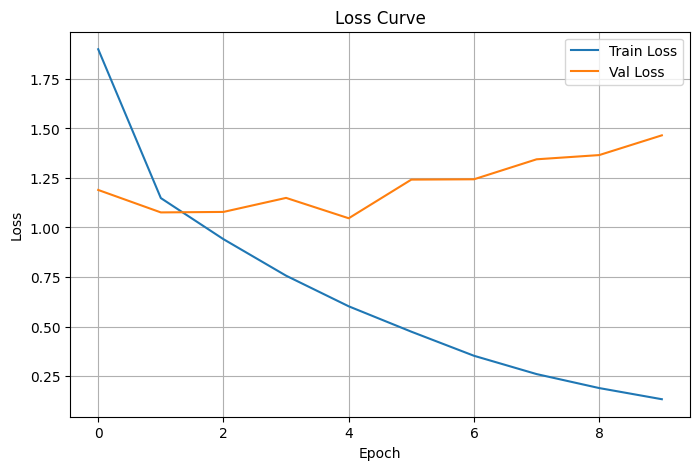

In [38]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


In [39]:
test_loader = DataLoader(full_dataset, batch_size=32, shuffle=False)  # if you have separate test set, use it

model.eval()
all_labels = []
all_preds = []
all_probs = []

test_start = time.time()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)

        _, pred = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(pred.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

test_end = time.time()
print(f"Testing Wall-clock Time: {test_end - test_start:.2f} sec")


Testing Wall-clock Time: 28.46 sec


In [40]:
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

overall_acc = (all_labels == all_preds).mean()
print("Overall Accuracy:", overall_acc)

per_class_acc = {}
for i, c in enumerate(class_names):
    idx = (all_labels == i)
    per_class_acc[c] = (all_preds[idx] == i).mean()

per_class_acc


Overall Accuracy: 0.9144082332761578


{'Baim': 0.8441176470588235,
 'Bata': 0.9461538461538461,
 'Batasio(tenra)': 0.89375,
 'Chitul': 0.9836734693877551,
 'Croaker(Poya)': 0.9181818181818182,
 'Hilsha': 0.9185185185185185,
 'Kajoli': 0.91875,
 'Meni': 0.896774193548387,
 'Pabda': 0.9116279069767442,
 'Poli': 0.9529411764705882,
 'Puti': 0.9178571428571428,
 'Rita': 0.8692307692307693,
 'Rui': 0.9157894736842105,
 'Rupchada': 0.86875,
 'Silver Carp': 0.9142857142857143,
 'Telapiya': 0.9217391304347826,
 'carp': 0.9481481481481482,
 'k': 0.8317073170731707,
 'kaikka': 0.9125,
 'koral': 0.9555555555555556,
 'shrimp': 0.9653846153846154}

In [41]:
print(classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    digits=4
))


                precision    recall  f1-score   support

          Baim     0.9349    0.8441    0.8872       340
          Bata     0.9425    0.9462    0.9443       260
Batasio(tenra)     0.8589    0.8938    0.8760       320
        Chitul     0.9777    0.9837    0.9807       490
 Croaker(Poya)     0.9619    0.9182    0.9395       110
        Hilsha     0.9118    0.9185    0.9151       270
        Kajoli     0.9323    0.9187    0.9255       480
          Meni     0.8742    0.8968    0.8854       310
         Pabda     0.8770    0.9116    0.8940       430
          Poli     0.9529    0.9529    0.9529       170
          Puti     0.9312    0.9179    0.9245       280
          Rita     0.9826    0.8692    0.9224       130
           Rui     0.8923    0.9158    0.9039       190
      Rupchada     0.9789    0.8688    0.9205       160
   Silver Carp     0.9412    0.9143    0.9275       140
      Telapiya     0.9381    0.9217    0.9298       230
          carp     0.9242    0.9481    0.9360  

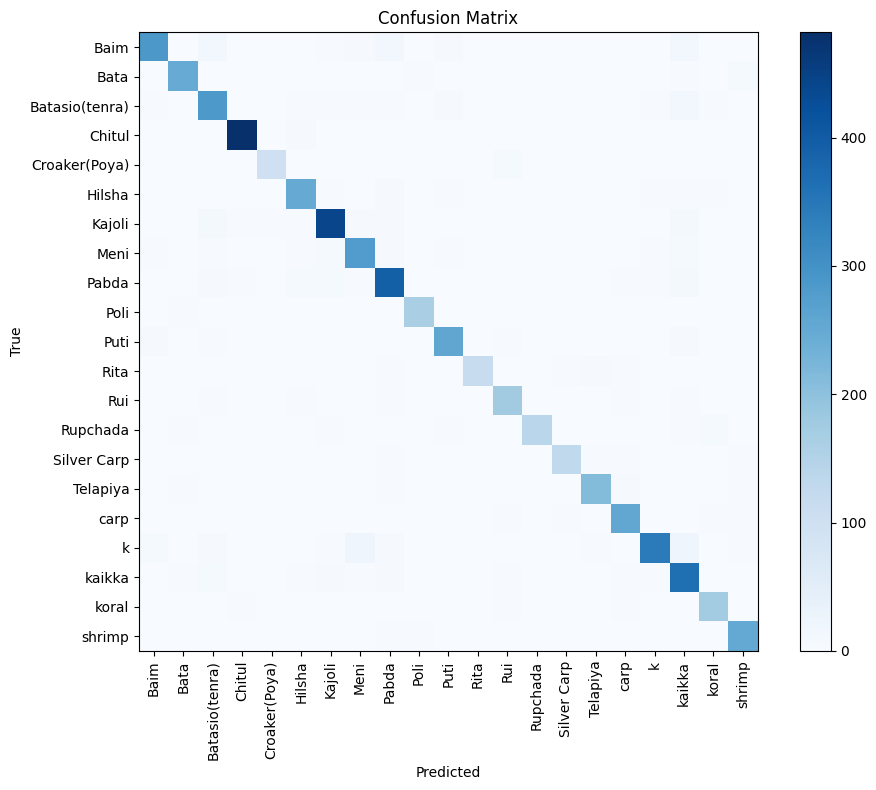

In [42]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, rotation=90)
plt.yticks(np.arange(len(class_names)), class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [43]:
y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))
y_prob = np.array(all_probs)

macro_auc = roc_auc_score(y_true_bin, y_prob, average="macro", multi_class="ovr")
print("Macro ROC–AUC:", macro_auc)


Macro ROC–AUC: 0.9945062639936856


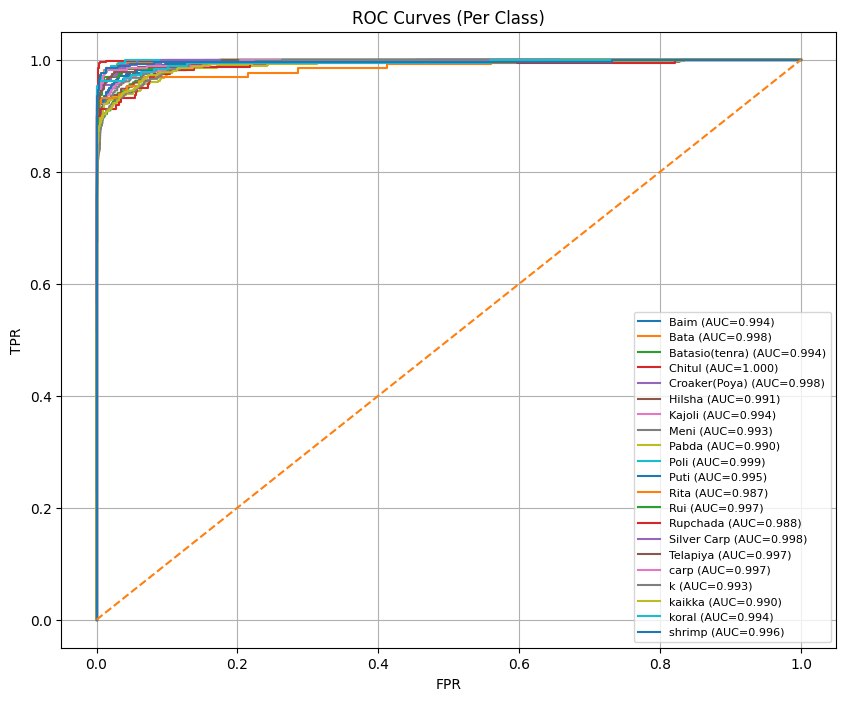

In [44]:
plt.figure(figsize=(10,8))

for i, cls in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    auc_val = roc_auc_score(y_true_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f"{cls} (AUC={auc_val:.3f})")

plt.plot([0,1],[0,1],'--')
plt.title("ROC Curves (Per Class)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid(True)
plt.legend(fontsize=8)
plt.show()


In [45]:
!pip install thop
from thop import profile

dummy = torch.randn(1,3,224,224).to(device)
flops, params = profile(model, inputs=(dummy,))

print(f"GFLOPs per inference: {flops/1e9:.3f}")
print(f"Parameters (M): {params/1e6:.2f}")


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
GFLOPs per inference: 4.132
Parameters (M): 23.55


In [46]:
cm = confusion_matrix(all_labels, all_preds)
np.fill_diagonal(cm, 0)

flat = cm.flatten()
idx = flat.argsort()[-5:][::-1]

print("Top Confused Class Pairs:")
for i in idx:
    r = i // num_classes
    c = i % num_classes
    print(f"{class_names[r]} → {class_names[c]} | Count = {cm[r,c]}")


Top Confused Class Pairs:
k → kaikka | Count = 21
k → Meni | Count = 20
Baim → Pabda | Count = 14
Batasio(tenra) → kaikka | Count = 14
Baim → Batasio(tenra) | Count = 13
